In [1]:
# Arquivo integrante do projeto para identificação dos preditores mais correlacionados 
# aos óbitos por COVID no Brasil, apresentado à PUC-MINAS como TCC

# Ajuste dos hiperparâmetros do modelo LogisticRegression

In [2]:
%run ./funcoes.ipynb

In [3]:
from sklearn.model_selection import train_test_split
#Carga dos dados já parcialmente tratados
#Produzida pelo notebook COVID_Preprocessamento.ipynb
arquivo_base = "INFLUD21-29-03-2021.csv"  
ext_file = "_processed_pre_dummies.csv"
rad_filename = arquivo_base[:-4]  #exclui a extensão do arquivo
filename_pre_des = rad_filename + ext_file
covid_df = load_df(filename_pre_des,";",None,None)  #carrega os dados

In [4]:
# Divisão da base de dados em treino e teste
# Dado o alto custo computacional, será usada pequena amostra dos dados para buscar os parâmetros
covid_df_train, covid_df_test = train_test_split(covid_df,test_size=0.95,random_state=42) 

In [5]:
covid_df_train.shape

(12747, 43)

Arquivo informado: INFLUD21-29-03-2021.csv
Verifica existencia do arquivo: True
Arquivo INFLUD21-29-03-2021_143_proc_smote_over.csv foi encontrado.
Carregando o arquivo...
Concluído.


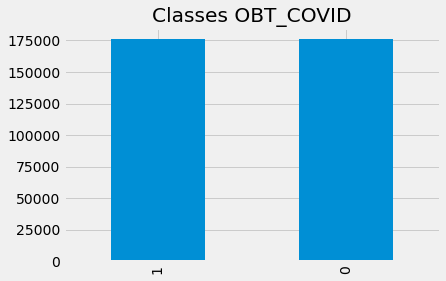

In [6]:
#Converte os tipos das variaveis do dataframe
covid_df_train_cat = converte_tipo_category(covid_df_train)
#Converte as variáveis categóricas em binárias (dummies)
covid_df_train_bin = converte_binarios(covid_df_train_cat) 
#Normalizada as colunas contínuas
covid_df_train_nor = normaliza_dados(covid_df_train_bin)
# Balanceamento da base de desenvolvimento Com SMOTE oversampling
covid_df_train_bal = imblearn_SMOTE_oversampling(covid_df_train_nor,arquivo_base,False,'OBT_COVID')

In [7]:
#Exibe o dataset balanceado
covid_df_train_bal

,NU_IDADE_N,GeoSES,AN_SARS2_1.0,AN_SARS2_9.0,ASMA_1.0,ASMA_2.0,ASMA_9.0,CARDIOPATI_1.0,CARDIOPATI_2.0,CARDIOPATI_9.0,...,UTI_1.0,UTI_2.0,UTI_9.0,VACINA_1.0,VACINA_2.0,VACINA_9.0,VOMITO_1.0,VOMITO_2.0,VOMITO_9.0,OBT_COVID
0,0.646154,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0.546154,0.662604,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
2,0.669231,0.662604,0,1,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,0.600000,0.662604,0,1,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
4,0.661538,0.662604,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351835,0.507239,0.562543,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,1,1
351836,0.466494,0.481421,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,1
351837,0.491169,0.546128,0,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
351838,0.561398,0.482540,0,1,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1


In [8]:
#Separação das variáveis independentes da dependente
labels = covid_df_train_bal.columns[:-1]  # presume-se que a última variável do dataframe é a alvo
X = covid_df_train_bal[labels].to_numpy()
y = covid_df_train_bal['OBT_COVID'].to_numpy()

In [9]:
# "Grid searching" dos hiperparametros para LogisticRegression

In [10]:
# define o modelo e os parâmetros a pesquisar
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [11]:
# Define e realiza o grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)

In [12]:
# Exibe os resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Melhor: 0.876660 usando {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.876532 (0.001533) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.875366 (0.001422) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.876530 (0.001544) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.876542 (0.001547) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.875333 (0.001428) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.876607 (0.001557) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.876660 (0.001535) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.875532 (0.001489) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.876588 (0.001589) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.876531 (0.001467) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.875645 (0.001511) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.875731 (0.001449) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.875167 (0.001360) 